In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric~=2.0.4 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q captum==0.6.0

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.4/943.4 kB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.5/407.5 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.9 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool, GNNExplainer

dataset = TUDataset(root='data/TUDataset', name='MUTAG').shuffle()

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

class GIN(nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        h = torch.cat((h1, h2, h3), dim=1)

        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return F.log_softmax(h, dim=1)

model = GIN(dim_h=32)

@torch.inference_mode()
def test(model, loader):
    loss_fn = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += loss_fn(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 200

model.train()
for epoch in range(epochs+1):
    total_loss = 0
    acc = 0
    val_loss = 0
    val_acc = 0

    # Train on batches
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fn(out, data.y)
        total_loss += loss / len(train_loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(train_loader)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss, val_acc = test(model, val_loader)

    # Print metrics every 20 epochs
    if(epoch % 20 == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

test_loss, test_acc = test(model, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


Epoch   0 | Train Loss: 1.04 | Train Acc: 68.99% | Val Loss: 0.85 | Val Acc: 52.63%
Epoch  20 | Train Loss: 0.37 | Train Acc: 81.44% | Val Loss: 0.43 | Val Acc: 84.21%
Epoch  40 | Train Loss: 0.31 | Train Acc: 87.64% | Val Loss: 0.46 | Val Acc: 84.21%
Epoch  60 | Train Loss: 0.22 | Train Acc: 90.20% | Val Loss: 0.58 | Val Acc: 68.42%
Epoch  80 | Train Loss: 0.26 | Train Acc: 90.67% | Val Loss: 0.53 | Val Acc: 73.68%
Epoch 100 | Train Loss: 0.41 | Train Acc: 80.97% | Val Loss: 0.77 | Val Acc: 78.95%
Epoch 120 | Train Loss: 0.22 | Train Acc: 87.64% | Val Loss: 0.47 | Val Acc: 84.21%
Epoch 140 | Train Loss: 0.16 | Train Acc: 90.77% | Val Loss: 0.41 | Val Acc: 84.21%
Epoch 160 | Train Loss: 0.29 | Train Acc: 83.00% | Val Loss: 0.40 | Val Acc: 78.95%
Epoch 180 | Train Loss: 0.23 | Train Acc: 88.68% | Val Loss: 0.46 | Val Acc: 84.21%
Epoch 200 | Train Loss: 0.21 | Train Acc: 86.22% | Val Loss: 0.47 | Val Acc: 78.95%
Test Loss: 0.49 | Test Acc: 84.21%


In [3]:
explainer = GNNExplainer(model, epochs=100, num_hops=1)
data = dataset[-1]
feature_mask, edge_mask = explainer.explain_graph(data.x, data.edge_index)
feature_mask

Explain graph: 100%|██████████| 100/100 [00:00<00:00, 203.33it/s]


tensor([0.2638, 0.2806, 0.2582, 0.2714, 0.2618, 0.2802, 0.2754])

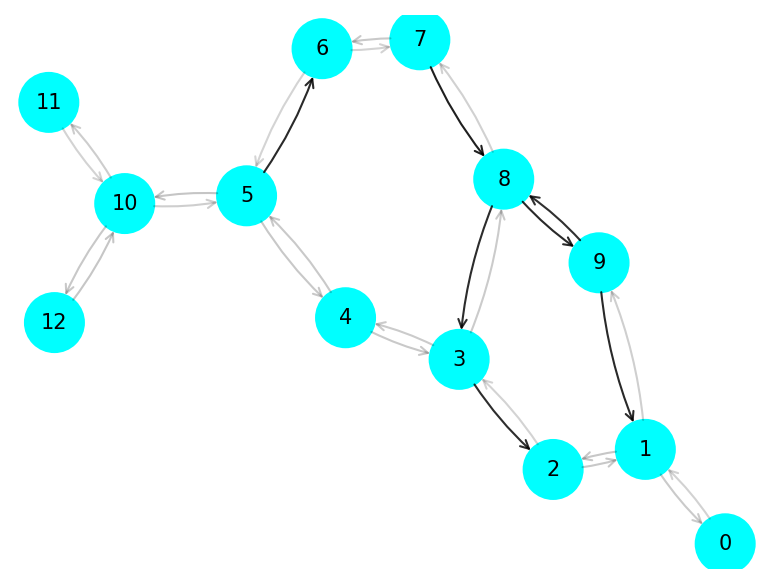

In [5]:
fig = plt.figure(dpi=150)
ax, G = explainer.visualize_subgraph(-1, data.edge_index, edge_mask, y=data.y)
ax.axis('off')
plt.show()

# Explaining GNNs with Integrated Gradients

In [6]:
!pip install -q captum

In [13]:
import numpy as np
from tqdm import tqdm
from captum.attr import IntegratedGradients

import torch_geometric.transforms as T
from torch_geometric.datasets import Twitch
from torch_geometric.nn import Explainer, GCNConv, to_captum

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

dataset = Twitch('.', name="EN")
data = dataset[0]

In [14]:
# two-layer GCN
class GCN(nn.Module):
  def __init__(self, hidden):
    super().__init__()
    self.conv1 = GCNConv(dataset.num_features, hidden)
    self.conv2 = GCNConv(hidden, dataset.num_classes)

  def forward(self, x, edge_index):
    h = self.conv1(x, edge_index).relu()
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.conv2(h, edge_index)
    return F.log_softmax(h, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# training loop
for epoch in tqdm(range(200)):
  model.train()
  optimizer.zero_grad()
  log_logits = model(data.x, data.edge_index)
  loss = F.nll_loss(log_logits, data.y)
  loss.backward()
  optimizer.step()

def accuracy(pred_y, y):
  return ((pred_y == y).sum() / len(y)).item()

@torch.inference_mode()
def test(model, data):
  model.eval()
  out = model(data.x, data.edge_index)
  acc = accuracy(out.argmax(dim=1), data.y)
  return acc

acc = test(model, data)
print(f'Test acc: {acc*100:.2f}%')

100%|██████████| 200/200 [00:02<00:00, 94.25it/s] 


Test acc: 77.94%


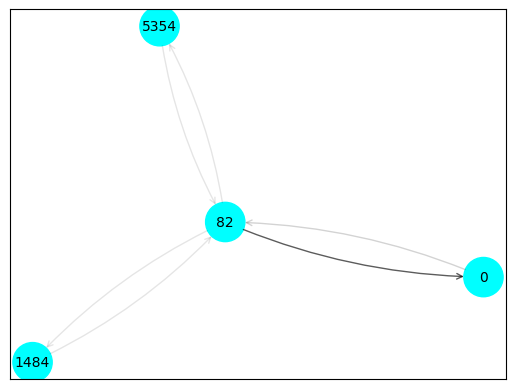

In [15]:
# specifying the node to explain: node 0
node_idx = 0

# convert PyG mdoel to Captum
captum_model = to_captum(model, mask_type='node_and_edge', output_idx=node_idx)

# create the integrated gradients object
ig = IntegratedGradients(captum_model)

# creste a tensor for every edge masks
edge_mask = torch.ones(data.num_edges, requires_grad=True, device=device)

# calculating attributes of nodes and edges
attr_node, attr_edge = ig.attribute(
    (data.x.unsqueeze(0), edge_mask.unsqueeze(0)),
    target=int(data.y[node_idx]),
    additional_forward_args=(data.edge_index),
    internal_batch_size=1)

# scaling the attributes
attr_node = attr_node.squeeze(0).abs().sum(dim=1)
attr_node /= attr_node.max()
attr_edge = attr_edge.squeeze(0).abs()
attr_edge /= attr_edge.max()

# plot the explaiation
explainer = Explainer(model)
ax, G = explainer.visualize_subgraph(node_idx, data.edge_index,
                                     attr_edge, node_alphs=attr_node,
                                     y=data.y)
plt.show()

Node 0’s subgraph comprises blue nodes, which share the same class. We can see that node 82 is the
most important node (other than 0) and the connection between these two nodes is the most critical
edge. This is a straightforward explanation: we have a group of four streamers using the same language.
The mutual friendship between nodes 0 and 82 is a good argument for this prediction.

Explanation for node 101’s classification

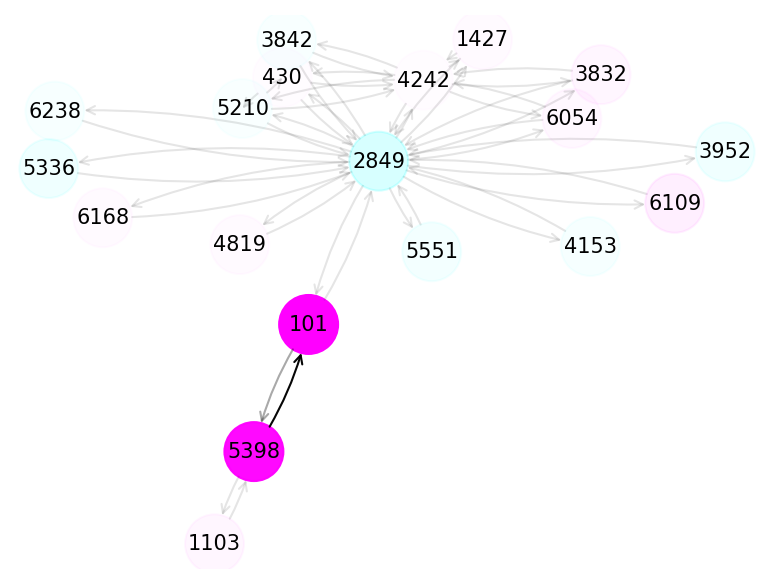

In [18]:
node_idx = 101
captum_model = to_captum(model, mask_type='node_and_edge', output_idx=node_idx)
ig = IntegratedGradients(captum_model)
edge_mask = torch.ones(data.num_edges, requires_grad=True, device=device)

attr_node, attr_edge = ig.attribute(
    (data.x.unsqueeze(0), edge_mask.unsqueeze(0)),
    target=int(data.y[node_idx]),
    additional_forward_args=(data.edge_index),
    internal_batch_size=1)

attr_node = attr_node.squeeze(0).abs().sum(dim=1)
attr_node /= attr_node.max()
attr_edge = attr_edge.squeeze(0).abs()
attr_edge /= attr_edge.max()

fig = plt.figure(dpi=150)
explainer = Explainer(model)
ax, G = explainer.visualize_subgraph(node_idx, data.edge_index, attr_edge, node_alpha=attr_node, y=data.y)
ax.axis('off')
plt.show()

In this case, our target node is connected to neighbors with different classes (nodes 5398 and 2849).
Integrated gradients give greater importance to the node that shares the same class as node 101. We
also see that their connection is the one that contributed the most to this classification. This subgraph
is richer; you can see that even two-hop neighbors contribute a little.